In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Mount Drive and Load Data

To create the training dataset, upload the `features_ring.pkl` file or `features_ring` folder, updating the path accordingly.

If this notebook is runned in colab, run this cell.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change the path accordingly to the execution enviroment (e.g. Colab or locally)

In [ ]:
path = 'drive/MyDrive' # Replace with your path if needed (in case of local execution)

Retrieve the dataset

In [ ]:
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

### Dropping duplicates prioritizing classes with higher frequency

In [3]:
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [4]:
df['class_freq'] = df['Interaction'].map(interaction_counts)
df = df.sort_values('class_freq', ascending=False)

columns_to_check = df.columns[:-2]
df = df.drop_duplicates(subset=columns_to_check, keep='last')
df = df.drop(columns=['class_freq'])

print("\nClass counts after deduplication:")
print(df['Interaction'].value_counts())


Class counts after deduplication:
Interaction
Unclassified    1089547
VDW              693266
HBOND            673450
PIPISTACK         37885
IONIC             35391
PICATION           8529
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


Add the label `Unclassified` to None values in the column `Interaction`

In [5]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')

Mapping the string labels to numericals

In [ ]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

y = df['Interaction'].replace(contact_dict)

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_22792/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


Apply a mask in order to get only the needed features to put in the dataset

In [ ]:
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

Encoding the categorical features and dropping the `3di_letter` since it represent the same thing of `3di_state`

In [ ]:
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

Counting the missing values in order to fill the rows with missing values by putting the mean value of the column

In [ ]:
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          15355
s_psi           5727
s_3di_state    31563
t_rsa             73
t_phi           5556
t_psi          18133
t_3di_state    37305
dtype: int64

Total missing values: 113775


Filling the rows with missing values with the mean of the values of that column

In [ ]:
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Double-check no missing values remain
total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

      s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  \
753   0.000 -1.093 -0.664 -1.019 -0.987 -1.505  1.266 -0.912          1.0   
1006  0.074  1.540 -0.085 -0.663 -1.524  2.219 -1.005  1.212         12.0   
418   0.180 -1.672 -0.253  0.260  0.830  3.097 -0.838  1.512         17.0   
413   0.294 -1.322 -0.254  1.050  0.302 -3.656 -0.259 -3.242         17.0   
412   0.049 -2.677  2.662 -1.337 -0.279 -0.544  1.242 -1.262          6.0   

      t_rsa  t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
753   0.893  1.168  0.631  1.831 -0.561  0.533 -0.277  1.648         12.0   
1006  0.028 -1.133 -0.543 -1.337 -0.279 -0.544  1.242 -1.262         17.0   
418   0.346 -1.801  0.850  1.831 -0.561  0.533 -0.277  1.648         12.0   
413   0.586  1.139  0.414  0.945  0.828  1.299 -0.169  0.933         14.0   
412   0.229 -2.085  2.109 -0.663 -1.524  2.219 -1.005  1.212          0.0   

      s_ss8_encoded  t_ss8_encod

This cell it is necessary for eventually engine some features and mandatory for `feature_importance` method

In [10]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

## Feature engineering


For each `features` are computed the following math operations:
*   Sum
*   Product
*   Absolute difference
*   Average

In [11]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names


Append the new features created

In [12]:
for feature in features:
  feature_names.extend(fe(feature))

Engineering feature: ss8_encoded
      s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  \
753   0.000 -1.093 -0.664 -1.019 -0.987 -1.505  1.266 -0.912          1.0   
1006  0.074  1.540 -0.085 -0.663 -1.524  2.219 -1.005  1.212         12.0   
418   0.180 -1.672 -0.253  0.260  0.830  3.097 -0.838  1.512         17.0   
413   0.294 -1.322 -0.254  1.050  0.302 -3.656 -0.259 -3.242         17.0   
412   0.049 -2.677  2.662 -1.337 -0.279 -0.544  1.242 -1.262          6.0   

      t_rsa  ...   t_a3   t_a4   t_a5  t_3di_state  s_ss8_encoded  \
753   0.893  ...  0.533 -0.277  1.648         12.0              4   
1006  0.028  ... -0.544  1.242 -1.262         17.0              8   
418   0.346  ...  0.533 -0.277  1.648         12.0              8   
413   0.586  ...  1.299 -0.169  0.933         14.0              8   
412   0.229  ...  2.219 -1.005  1.212          0.0              2   

      t_ss8_encoded  ss8_encoded_sum  ss8_encoded_abs_diff  ss8_encoded_prod  \
753      

## Splitting dataset

In [14]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.1,
    random_state=42,   
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.1,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling

Computing the inital class distribution

In [ ]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 545494
1: 561545
2: 30687
3: 28667
4: 6908
5: 1701
6: 1450
7: 882533


Applying a sampling strategy in order to oversampling and computing new distribution

In [ ]:
sampling_strategy = {
    2: 250000,  # PIPISTACK
    3: 250000,  # IONIC
    4: 160000,  # PICATION
    5: 70000,  # SSBOND
    6: 70000,  # PIHBOND
}

oversample = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=42)

# Fit and resample the training data
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train_smote)):
    print(f"{label}: {Counter(y_train_smote)[label]}")

## XGBoost

### Helper functions

This method compute and plot the feature importance that contributes to the prediction

In [ ]:
def feature_importance(model, feature_names):
  # Get feature importances from the model
  importance = model.get_score(importance_type='weight')

  # Mapping feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sorting the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Plotting the feature importance
  plt.figure(figsize=(10, 20))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  
  plt.tight_layout()
  plt.show()

Method that evaluates the models and compute the features importance

In [ ]:
import time

def evaluate_model(model, X_test, y_test, feature_names, selected_feature_indices=None):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    """

    # If selected_feature_indices is provided, filter the test data
    if selected_feature_indices is not None:
        X_test = X_test[:, selected_feature_indices]
    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),
            matthews_corrcoef(y_test, y_pred),
            average_precision_score(y_test, y_pred_prob),
            inference_time * 1000,
        ]
    }

    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics =====")
    print(metrics_df.set_index('Metric').round(4))

    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"\n===== Feature Importance =====")

    # Compute feature importance
    feature_importance(model, feature_names)

    return metrics_df, y_pred_prob

### Train loop

### Without SMOTE

/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:11:52] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	mlogloss-mlogloss:2.00953	mlogloss-merror:0.30517
[10]	mlogloss-mlogloss:1.55509	mlogloss-merror:0.26705
[20]	mlogloss-mlogloss:1.29901	mlogloss-merror:0.26245
[30]	mlogloss-mlogloss:1.12954	mlogloss-merror:0.26224
[40]	mlogloss-mlogloss:1.01124	mlogloss-merror:0.26224
[50]	mlogloss-mlogloss:0.92590	mlogloss-merror:0.26149
[60]	mlogloss-mlogloss:0.86326	mlogloss-merror:0.26073
[70]	mlogloss-mlogloss:0.81638	mlogloss-merror:0.26006
[80]	mlogloss-mlogloss:0.78148	mlogloss-merror:0.25787
[90]	mlogloss-mlogloss:0.75545	mlogloss-merror:0.25817
[100]	mlogloss-mlogloss:0.73546	mlogloss-merror:0.25741
[110]	mlogloss-mlogloss:0.72027	mlogloss-merror:0.25694
[120]	mlogloss-mlogloss:0.70862	mlogloss-merror:0.25800
[130]	mlogloss-mlogloss:0.69991	mlogloss-merror:0.25951
[134]	mlogloss-mlogloss:0.69697	mlogloss-merror:0.25859

===== Performance Metrics =====
                          Value
Metric                         
Accuracy                 0.4856
Balanced Accuracy        0.7309
AUC-ROC   

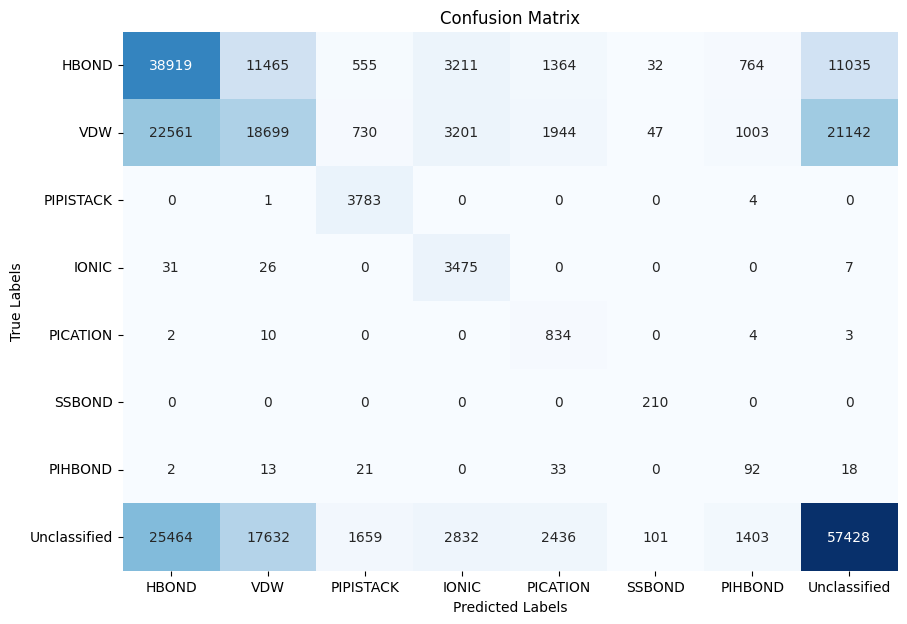


===== Feature Importance =====


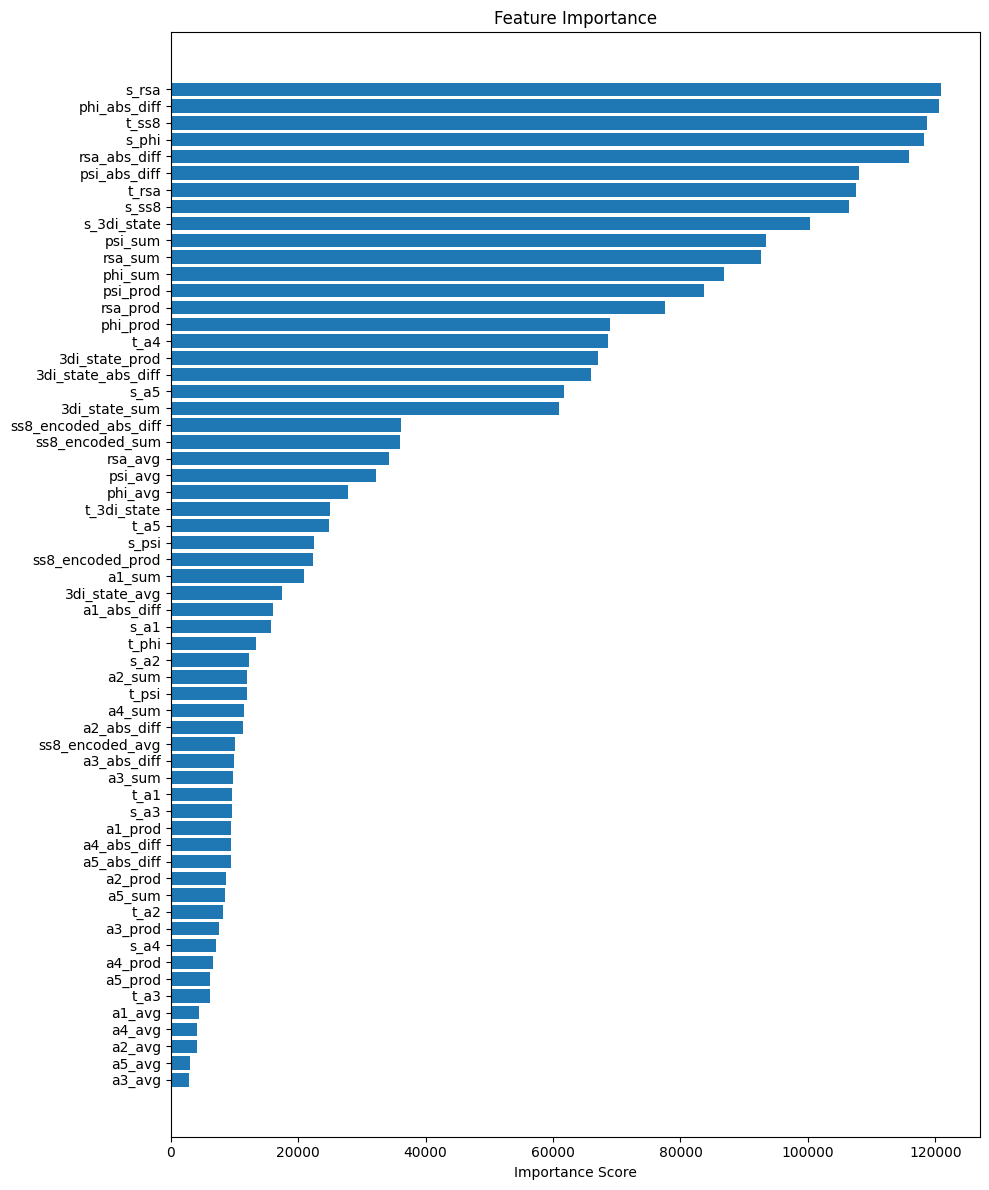

(                 Metric        Value
 0              Accuracy     0.485610
 1     Balanced Accuracy     0.730874
 2               AUC-ROC     0.871005
 3  Matthews Correlation     0.275329
 4     Average Precision     0.501642
 5   Inference Time (ms)  6080.619097,
 array([[0.31620002, 0.32184023, 0.01252919, ..., 0.01254281, 0.01247603,
         0.29926825],
        [0.28314796, 0.34394962, 0.01236864, ..., 0.01238205, 0.01231589,
         0.3110706 ],
        [0.3589321 , 0.30078402, 0.01410194, ..., 0.01411583, 0.01417421,
         0.26967484],
        ...,
        [0.21892641, 0.25782388, 0.0136875 , ..., 0.01370243, 0.0136345 ,
         0.45475617],
        [0.25679392, 0.36297983, 0.01286933, ..., 0.01288034, 0.01804408,
         0.31060955],
        [0.10052148, 0.27540722, 0.01219686, ..., 0.01221004, 0.0121486 ,
         0.56303716]], shape=(254196, 8), dtype=float32))

In [22]:
weights_train = compute_sample_weight('balanced', y_train)
weights_val = compute_sample_weight('balanced', y_val)

# Use these weights in DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
dval = xgb.DMatrix(X_val, label=y_val, weight=weights_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train model
model = xgb.train(
    params = {
        'device': 'cuda',
        'seed': 42,
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'eval_metric': ['mlogloss', 'merror'],
        'max_depth': 15,
        'learning_rate': 0.03,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'colsample_bylevel': 0.8,  
        'gamma': 0.1,               
        'reg_alpha': 0.1,           
        'reg_lambda': 1.0,          
        'min_child_weight': 3,     
    },
    dtrain=dtrain,
    num_boost_round=10000,
    evals=[(dval, 'mlogloss')],
    early_stopping_rounds=50,
    verbose_eval=10,
)


# Save model
os.makedirs(os.path.join(path, 'models'), exist_ok=True)
model.save_model(os.path.join(path, f'models/xgboost_model_mcc.json'))

evaluate_model(model, X_test, y_test, feature_names)


### With SMOTE

[0]	mlogloss-mlogloss:2.05495	mlogloss-merror:0.58191
[1]	mlogloss-mlogloss:2.03130	mlogloss-merror:0.57334
[2]	mlogloss-mlogloss:2.00794	mlogloss-merror:0.57271
[3]	mlogloss-mlogloss:1.98505	mlogloss-merror:0.56555
[4]	mlogloss-mlogloss:1.96268	mlogloss-merror:0.56618
[5]	mlogloss-mlogloss:1.94130	mlogloss-merror:0.56632
[6]	mlogloss-mlogloss:1.92026	mlogloss-merror:0.56633
[7]	mlogloss-mlogloss:1.89982	mlogloss-merror:0.56666
[8]	mlogloss-mlogloss:1.87973	mlogloss-merror:0.56595
[9]	mlogloss-mlogloss:1.86014	mlogloss-merror:0.56479
[10]	mlogloss-mlogloss:1.84124	mlogloss-merror:0.56407
[11]	mlogloss-mlogloss:1.82277	mlogloss-merror:0.56434
[12]	mlogloss-mlogloss:1.80475	mlogloss-merror:0.56390
[13]	mlogloss-mlogloss:1.78759	mlogloss-merror:0.56372
[14]	mlogloss-mlogloss:1.77081	mlogloss-merror:0.56384
[15]	mlogloss-mlogloss:1.75455	mlogloss-merror:0.56381
[16]	mlogloss-mlogloss:1.73855	mlogloss-merror:0.56361
[17]	mlogloss-mlogloss:1.72307	mlogloss-merror:0.56328
[18]	mlogloss-mloglo

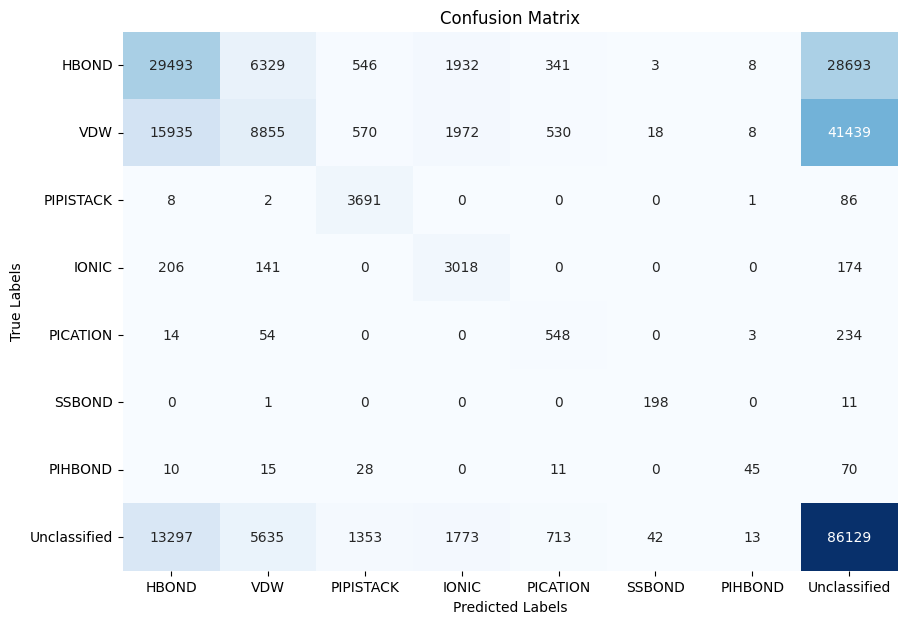


===== Feature Importance =====


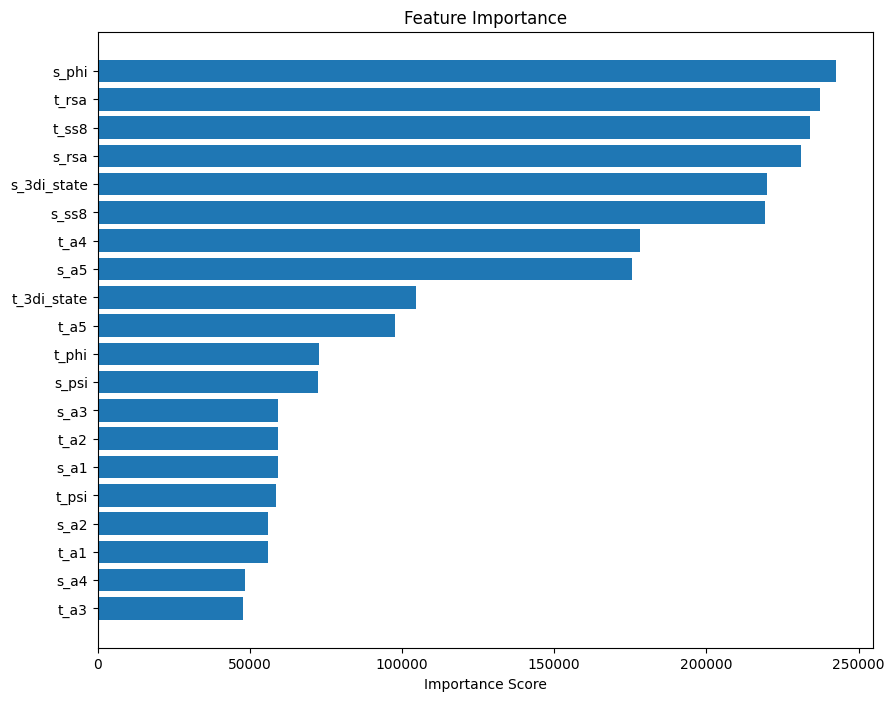

(                 Metric        Value
 0              Accuracy     0.519194
 1     Balanced Accuracy     0.627504
 2               AUC-ROC     0.877332
 3  Matthews Correlation     0.277809
 4     Average Precision     0.546505
 5   Inference Time (ms)  2546.902895,
 array([[2.6649755e-01, 3.2621047e-01, 7.8357243e-07, ..., 1.3887437e-08,
         1.6698318e-06, 4.0728781e-01],
        [4.9671668e-01, 2.0586993e-01, 8.8410289e-08, ..., 4.5990348e-08,
         1.9572944e-06, 2.9741007e-01],
        [3.9854205e-01, 2.5787616e-01, 3.5813935e-07, ..., 5.1554146e-08,
         2.2591521e-06, 3.4357792e-01],
        ...,
        [3.4480414e-01, 3.5408205e-01, 1.2008269e-06, ..., 1.0460906e-07,
         2.2764949e-04, 3.0088255e-01],
        [4.8476285e-01, 3.1678212e-01, 8.0394955e-08, ..., 1.2485253e-07,
         3.5963698e-08, 1.9845328e-01],
        [2.8827709e-01, 2.2645834e-01, 2.5202274e-07, ..., 6.4462490e-08,
         1.2460894e-05, 4.8524904e-01]], dtype=float32))

In [ ]:
#weights_train = compute_sample_weight('balanced', y_train_smote)
#weights_val = compute_sample_weight('balanced', y_val)

dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train model
model = xgb.train(
    params = {
        'device': 'cuda',
        'seed': 42,
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'eval_metric': ['mlogloss', 'merror'],  
        'max_depth': 8,
        'learning_rate': 0.03,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'max_delta_step': 1,  
    },
    dtrain=dtrain,
    num_boost_round=10000,
    evals=[(dval, 'mlogloss')],
    early_stopping_rounds=50,
    verbose_eval=1
)

# Save model
os.makedirs(os.path.join(path, 'models'), exist_ok=True)
model.save_model(os.path.join(path, f'models/xgboost_model_mcc.json'))

evaluate_model(model, X_test, y_test, feature_names)


## Feature Selection

Feature importance threshold: 67211.9600
Total features with importance scores: 50
Selected 20 features out of 60
Top 10 selected features: ['phi_abs_diff', 's_rsa', 's_phi', 't_ss8', 'psi_abs_diff', 'rsa_abs_diff', 't_rsa', 's_ss8', 's_3di_state', 'rsa_sum']


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:54:22] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


[0]	eval-mlogloss:1.97637
[100]	eval-mlogloss:1.06838
[200]	eval-mlogloss:1.05553
[300]	eval-mlogloss:1.05052
[400]	eval-mlogloss:1.04785
[500]	eval-mlogloss:1.04614
[600]	eval-mlogloss:1.04536
[700]	eval-mlogloss:1.04497
[800]	eval-mlogloss:1.04489
[900]	eval-mlogloss:1.04500
[1000]	eval-mlogloss:1.04533
[1100]	eval-mlogloss:1.04572
[1200]	eval-mlogloss:1.04621
[1300]	eval-mlogloss:1.04686
[1354]	eval-mlogloss:1.04719

===== Performance Metrics =====
                           Value
Metric                          
Accuracy                  0.4920
Balanced Accuracy         0.2098
AUC-ROC                   0.7430
Matthews Correlation      0.2008
Average Precision         0.2317
Inference Time (ms)   61048.1369


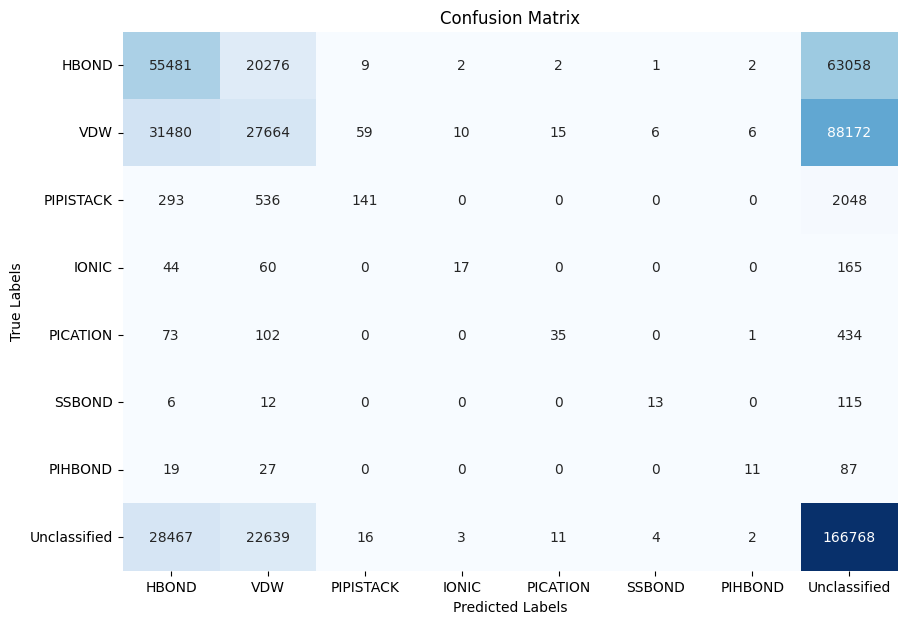


===== Feature Importance =====


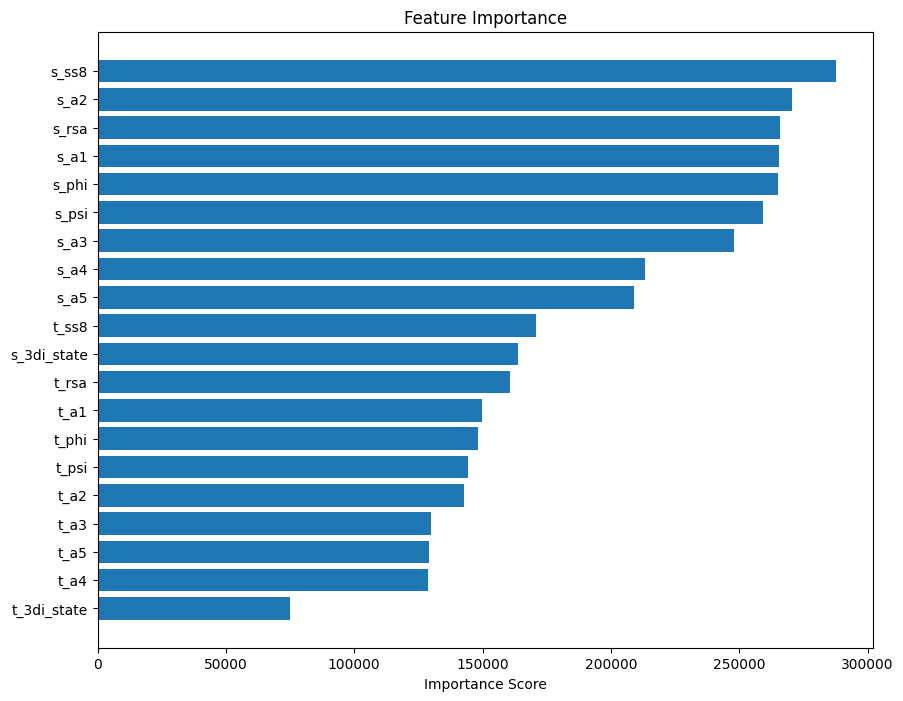

Pruned model saved to models_pruned_mean_threshold/xgboost_model_multiclass_pruned.json


In [ ]:
model_path = '/models/mcc_models/xgboost_model_mcc.json'
model = xgb.Booster()
model.load_model(model_path)

# Get feature importances as a dictionary
importance = model.get_score(importance_type='weight')

# Extract the importance values and calculate their mean
if importance:
    importance_values = np.array(list(importance.values()))
    threshold = np.mean(importance_values)
    print(f"Feature importance threshold: {threshold:.4f}")
else:
    print(f"Warning: No feature importance scores found for the model. Skipping feature selection.")

# Get features sorted by importance
sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)
print(f"Total features with importance scores: {len(sorted_importance)}")

# Select features based on the threshold
selected_feature_indices = [int(key[1:]) for key, score in sorted_importance if score > threshold]

if not selected_feature_indices:
    print(f"Warning: No features selected with threshold {threshold}. Using top 10 features instead.")
    # Fallback to top N features if threshold yields no features
    selected_feature_indices = [int(key[1:]) for key, _ in sorted_importance[:10]]

# Ensure selected_feature_indices are within bounds
max_feature_index = X_train.shape[1] - 1
selected_feature_indices = [idx for idx in selected_feature_indices if idx <= max_feature_index]

print(f"Selected {len(selected_feature_indices)} features out of {X_train.shape[1]}")

# Filter training/test data using selected indices
X_train_selected = X_train[:, selected_feature_indices]
X_test_selected = X_test[:, selected_feature_indices]

try:
    selected_features_names = [feature_names[idx] for idx in selected_feature_indices]
    print(f"Top 10 selected features: {selected_features_names[:10]}")
except NameError:
    print(f"Top 10 selected feature indices: {selected_feature_indices[:10]}")
    print("Cannot retrieve feature names: 'feature_names' variable not found.")

dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
dtest_selected = xgb.DMatrix(X_test_selected, label=y_test)

# Train the pruned multi-class model
num_classes = len(np.unique(y_train))
fs_model = xgb.train(
    params={
        'device': 'cuda',
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'eval_metric': 'mlogloss',
        'max_depth': 10,
        'learning_rate': 0.1,
        'seed': 42
    },
    dtrain=dtrain_selected,
    num_boost_round=model.best_iteration + 1 if hasattr(model, 'best_iteration') else 100,
    evals=[(dtest_selected, 'eval')],
    verbose_eval=100
)

evaluate_model(fs_model, X_test, y_test, feature_names, selected_feature_indices=selected_feature_indices)

# Save the pruned model
output_dir = 'models/mcc_models_pruned_mean_threshold'
os.makedirs(output_dir, exist_ok=True)
fs_model.save_model(os.path.join(output_dir, 'xgboost_model_multiclass_pruned.json'))
print(f"Pruned model saved to {os.path.join(output_dir, 'xgboost_model_multiclass_pruned.json')}")